# Subspace partitioning
- The problem formulation (found in `our_problem_formulation.py`) performs aggregation across planning phases, while keeping results spatially disaggregated. The former hides a level of disaggregation we are currently not interested in, reducing complexity. The latter helps us to put strict constraints on the outcomes for Dike Rings 1 and 2 specifically, which is our area of interest.
- We use an efficient sampling method (`LHS`) to produce results for `10000` experiments for a high resolution input space for PRIM to operate in.
- We vary only uncertainties, keeping policy levers constant at zero policy
- The above is implemented in the `dike_model_simulation.py`, when the `CONFIG` variable is set to `'subspace'`.

In [1]:
import pandas as pd
from ema_workbench.analysis import prim
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\marno\.conda\envs\EPA1361\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


<Logger EMA (DEBUG)>

## 1. Import data
Here, we import the inputs and outputs running the model 10000 times with LHS sampling for all uncertainties and with zero policy.

In [2]:
path = '../data/scenario_discovery/'
exp_path = path + 'experiments_subspace_3.csv'
out_path = path + 'outcomes_subspace_3.csv'

In [3]:
exp_df = pd.read_csv(exp_path, index_col=0)
out_df = pd.read_csv(out_path)

There are no dike investment costs, no total RfR costs and no evacuation costs because there is no policy, so we can drop those columns

In [4]:
drop_cols = [col_name for col_name in out_df.columns if col_name[-21:] == 'Dike Investment Costs'] + ['RfR Total Costs'] + ['Expected Evacuation Costs']
#waarom plus en waarom buiten haakjes?
out_df.drop(drop_cols, axis=1, inplace=True)

In [5]:
print(f'experiments shape is {exp_df.shape}')
print(f'outcomes shape is {out_df.shape}')

# List outcomes for dike rings 1 and 2
print('\nOutcomes of local interest:')
for i, col_name in enumerate(out_df.columns):
    if '1' in col_name or '2' in col_name:
        print(f'{i}: {col_name}')

experiments shape is (10000, 53)
outcomes shape is (10000, 11)

Outcomes of local interest:
1: A.1 Expected Annual Damage
2: A.1_Expected Number of Deaths
3: A.2 Expected Annual Damage
4: A.2_Expected Number of Deaths


# 2. Explore and set thresholds
Next up, we can explore the scenarios and set thresholds to certain outcomes to find cases of interest. We should try not to aggregate, since that could mean one Dike Ring is preferred over another.  In order to treat all dike rings based on equal standards, we decide to set one common threshold regardless of their starting situation.

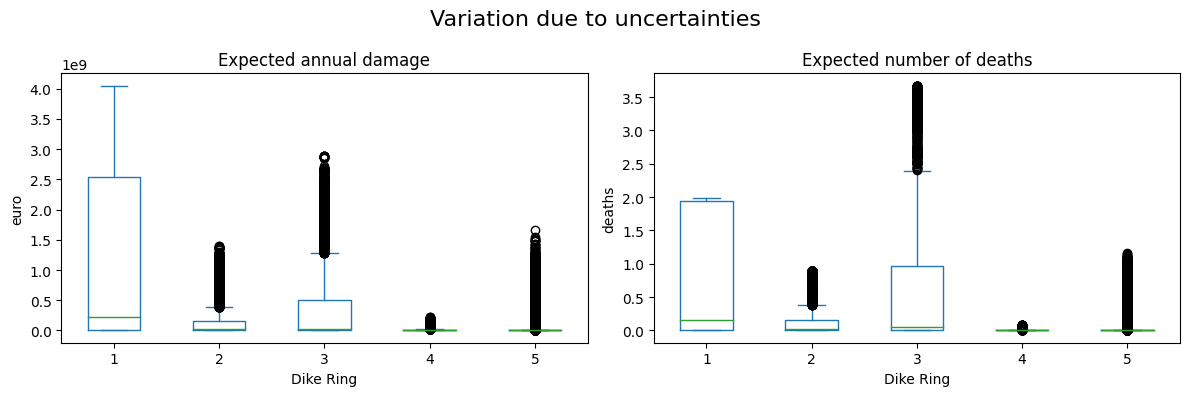

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
out_df.iloc[:, [1,3,5,7,9]].plot.box(ax = ax[0])
ax[0].set(xlabel='Dike Ring', ylabel='euro', title='Expected annual damage')
ax[0].set_xticklabels( (1, 2, 3, 4, 5))
out_df.iloc[:, [2,4,6,8,10]].plot.box(ax = ax[1])
ax[1].set(xlabel='Dike Ring', ylabel='deaths', title='Expected number of deaths')
ax[1].set_xticklabels( (1, 2, 3, 4, 5))
fig.suptitle('Variation due to uncertainties', fontsize=16)

fig.tight_layout()
fig.savefig(f'../img/distributions.png')

Our first observation is that Dike Ring 1 is most sensitive to uncertainties (especially damage). One exception is, that the more extreme scenarios are worse in terms of deaths for dike ring 3.

Our second observation is that the upper range of outcomes is very stretched out, meaning that low probability cases have high consequences. Especially in terms of damage costs, where we see (for dike ring 1) a factor 20 increase between the median and the most extreme case. In terms of deaths we see a factor 10 increase.

Based on the distribution in dike ring 1, we judge which magnitude of outcomes are highly alarming and should be included as an outcome of interest. We decided to put a damage cost threshold at the 60th percentile of dike ring 1, where costs reach a billion. Similarly, for deaths, we put a threshold at the 62nd percentile, where expected deaths reaches one. As discussed with the province, one death is already too many.

In [7]:
damage_threshold = np.percentile(out_df.iloc[:, 1], q=60).round(-8)
deaths_threshold = np.percentile(out_df.iloc[:, 2], q=62).round(1)
print(f'max damage: {damage_threshold / 10**9} billion eu \nmax deaths: {deaths_threshold}')

max damage: 1.0 billion eu 
max deaths: 0.9


Now we can generate outcomes of interests depending on the scope (local, province or broad)

In [8]:
broad_scope = pd.DataFrame()
damage_cols = [1, 3, 5, 7, 9]
deaths_cols = [2, 4, 6, 8, 10]

for col_sets, threshold in [(damage_cols, damage_threshold), (deaths_cols, deaths_threshold)]:
    for col in col_sets:
        name = out_df.columns[col]
        broad_scope[f'above threshold for {name}'] = (out_df[name] >= threshold)
local_scope = pd.concat([broad_scope.iloc[:, 0:2], broad_scope.iloc[:, 5:7]], axis=1)
province_scope = pd.concat([broad_scope.iloc[:, 0:3], broad_scope.iloc[:, 5:8]], axis=1)
province_scope.head(3)

,above threshold for A.1 Expected Annual Damage,above threshold for A.2 Expected Annual Damage,above threshold for A.3 Expected Annual Damage,above threshold for A.1_Expected Number of Deaths,above threshold for A.2_Expected Number of Deaths,above threshold for A.3_Expected Number of Deaths
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False


For completeness, we also add an aggregate scope for deaths and one for damage, where outcomes for all dike rings are taken in sum. Note that our shared vision within the province, is aggregated outcomes should not serve as primary indicators, since they may justify national policy decisions that produce spatial inequalities that we deem unfair.

In [9]:
agg_scope = pd.DataFrame({'Damages summed': out_df.iloc[:, damage_cols].sum(axis=1),
                          'Deaths summed': out_df.iloc[:, deaths_cols].sum(axis=1)})
print(agg_scope.sort_values(by='Damages summed', ascending=False).head(3))
print(agg_scope.sort_values(by='Deaths summed', ascending=False).head(3))

agg_damage_threshold = np.percentile(a=agg_scope['Damages summed'], q=90)
agg_deaths_threshold = np.percentile(a=agg_scope['Deaths summed'], q=90)

agg_damage = pd.DataFrame({'damage above agg threshold': (agg_scope['Damages summed'] >= agg_damage_threshold)})
agg_deaths = pd.DataFrame({'deaths above agg threshold': (agg_scope['Deaths summed'] >= agg_deaths_threshold)})

      Damages summed  Deaths summed
5618    6.785735e+09       5.988365
3764    6.771688e+09       5.305407
6740    6.730505e+09       5.233911
      Damages summed  Deaths summed
5618    6.785735e+09       5.988365
8514    5.823967e+09       5.932066
1146    5.578895e+09       5.894255


# 3. Execute PRIM for different scopes
Based on the scopes of outcomes we are interested in, we can execute PRIM for subspace partitioning. This will help us explore which parts of the input space produce unacceptable outcomes. To allow easy switching between scopes, we assign dfs to `select_scope`

In [10]:
SCOPE = 'local' # choose from: local, province, broad, agg_damage, agg_deaths

# dict to select the data that corresponds to the active scope
select_data = {'local': local_scope, 'province': province_scope, 'broad': broad_scope,
                'agg_damage': agg_damage, 'agg_deaths': agg_deaths}

scope_df = select_data[SCOPE]
out_df['unacceptable'] = (scope_df.sum(axis=1) >0)

print(out_df['unacceptable'].value_counts())
print('(True means that at least one outcome reached an unacceptable value)')

unacceptable
False    5759
True     4241
Name: count, dtype: int64
(True means that at least one outcome reached an unacceptable value)


[MainProcess/INFO] 10000 points remaining, containing 4241 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3579, coverage: 0.8439047394482433, density: 1.0 restricted_dimensions: 1


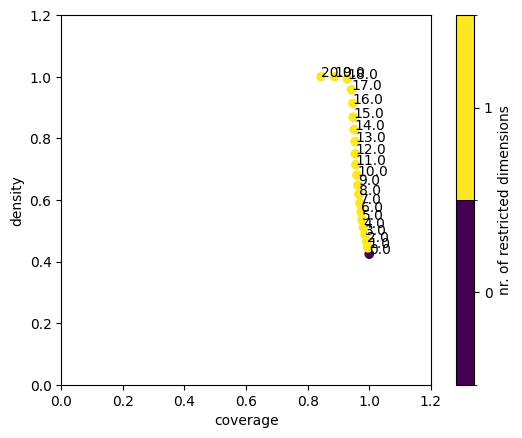

In [11]:
y = out_df['unacceptable'].values
x = exp_df.iloc[:, 0:-3]
prim_alg = prim.Prim(y = y, x = x, threshold=0.6, peel_alpha=0.05)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

We notice the graph always shows a line of points where $ \frac{\Delta density}{\Delta coverage}$ is negligably small, until an inflexion point where increasing density starts to cost us significant coverage. We always choose a point after this inflexion point, with preference for higher nr. of restricted dimensions. This results in the points assigned to `select_points`

In [12]:
# dict to select the chosen point that corresponds to the active scope
select_points = {'local': 18, 'province': 12, 'broad': 12,
                 'agg_damage': 23, 'agg_deaths': 46}

POINT = select_points[SCOPE]
box1.inspect(POINT)

coverage     0.928790
density      0.992942
id          18.000000
mass         0.396700
mean         0.992942
res_dim      1.000000
Name: 18, dtype: float64

             box 18                            
                min       max qp value qp value
A.1_pfail  0.000051  0.396689      NaN      0.0



[None]

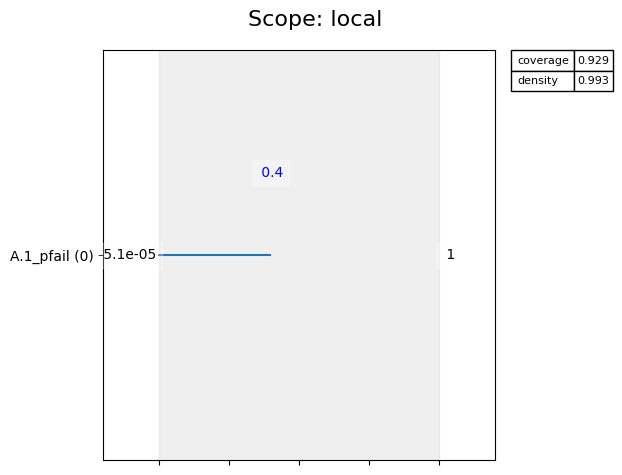

In [13]:
fig = box1.inspect(POINT, style="graph")
fig[0].suptitle(f'Scope: {SCOPE}', fontsize=16)
plt.tight_layout()
fig[0].savefig(f'../img/subspace_range_{SCOPE}.png')

What we learned:
 1. In terms of damage - whether taking an aggregate or a disaggregate approach - dike ring 1 is extremely vulnerable. All worst cases (> 1 billion annual costs) occur when A.1_pfail is under 0.4. Looking at the worst 10% cases of damage on an aggregate scale, the effect of the discount rate starts to become distinct.
2. Looking at the worst 10% cases of deaths on an aggregate scale, A.3_pfail is under 0.14, and A_1.pfail is above 0.18. This probably relates to the high population density in Zutphen, combined with a low to moderate flood risk.
3. Looking at a wider range of bad cases, Dike ring 1 is more vulnerable to deaths. Even though there is low population density, there is high flood risk.

# 4. Build reference scenarios

We decide to formulate nine reference scenarios<b>*</b>, eight of which range from standard to worst-case p_fail values, and vary between two discount rates. The ninth scenario is the most extreme case in terms of both aggregate damages and expected deaths. These scenarios can be used to test proposed policies for robustness.
1. Standard scenario: reference values
2. Standard scenario with discount rate = 1.5
3. Bad scenario: A.1_pfail value = 0.2
4. Bad scenario with discount rate = 1.5
5. Worst damage: A.1_pfail = 0.0
6. Worst damage with discount rate = 1.5
7. Worst deaths: A.1_pfail = 0.18, A.3_pfail = 0.0
8. Worst deaths with discount rate = 1.5
9. Extreme scenario: settings that lead to maximum total damage cost AND deaths (which is the same scenario)

<b>*NB: In the final Multi-Scenario MORDM phase, half of the scenarios had to be dropped due to computation times. Scenario's 2, 4, 6 and 9 are kept.</b>


In [14]:
# First, set the standard and the extreme scenarios

standard = {'scenario': 'standard', 'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 4, 'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5, 'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5}

extreme = {'scenario': 'extreme - agg', 'discount rate 0': 1.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 35, 'A.1_Bmax': 67.28, 'A.1_pfail': 0.04, 'A.1_Brate': 10.0, 'A.2_Bmax': 341.29, 'A.2_pfail': 0.03, 'A.2_Brate': 1.5, 'A.3_Bmax': 114.33, 'A.3_pfail': 0.0, 'A.3_Brate': 1.0, 'A.4_Bmax': 298.1, 'A.4_pfail': 0.91, 'A.4_Brate': 1.5, 'A.5_Bmax': 347.65, 'A.5_pfail': 0.98, 'A.5_Brate': 1.5}

# extreme = standard.copy()
# extreme_row = exp_df.iloc[agg_scope['Damages summed'].idxmax()]
# for key in standard.keys():
#     extreme[key] = extreme_row[key].round(2)
# print(extreme)

In [15]:
# Now, define how the other scenarios differ from standard, then build df from records
changes = {'standard - low disc': {'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5},
           'bad': {'A.1_pfail': 0.2},
           'bad - low disc': {'A.1_pfail': 0.2, 'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5},
           'worst damage': {'A.1_pfail': 0.0},
           'worst damage - low disc': {'A.1_pfail': 0.0, 'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5},
           'worst deaths': {'A.1_pfail': 0.18, 'A.3_pfail': 0.0},
           'worst deaths - low disc': {'A.1_pfail': 0.0, 'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5},
}

scenarios_listed = [standard]
for key, value in changes.items():
    scen = standard.copy()
    scen['scenario'] = key
    for k, v in value.items():
        scen[k] = v
    scenarios_listed.append(scen)
scenarios_listed.append(extreme)

In [40]:
# Combine
ref_scen_df = pd.concat([pd.DataFrame(scenario, index=[0]) for scenario in scenarios_listed])
# Drop scenarios that were eventually excluded
ref_scen_df = ref_scen_df[~ref_scen_df['scenario'].isin(['standard', 'bad', 'worst damage', 'worst deaths', 'worst deaths - low disc'])]
# Export to csv
ref_scen_df.reset_index(drop=True).to_csv(path+'reference_scenarios.csv')